# Apprentissage par renforcement

L'[apprentissage par renforcement](https://en.wikipedia.org/wiki/Reinforcement_learning) consiste à optimiser les actions d'un agent dans un environnement donné, selon un système d'action de l'agent vers l'environnement et de récompenses de l'environnement vers l'agent.

![Reinforcement Learning Scheme](fig/RL_scheme)

Sur la figure ci-dessus, est représentée la boucle traditionelle d'action/contre-réaction de l'agent et de l'environnement. À l'instant $t$, lorsque l'agent se trouve dans l'état (_state_) $S_t$, il prend la décision d'effectuer l'action (_action_) $A_t$. L'environnement réagit alors à sont tour sous l'effet de cette action en plaçant l'agent dans l'état $S_{t+1}$ et en renvoyant la récompense (_reward_) $R_{t+1}$ qui vont relancer un cycle de prise de décision de l'agent et de contre-réaction de l'environnement.

L'enjeu de l'apprentissage par renforcement est de trouver la façon d'agir (_policy_) permettant d'optimiser un gain de long-terme choisi.

Le cas typique d'usage de l'apprentissage par renforcement est l'exploration d'un environnement inconnu par un robot. Cet exemple est toutefois difficile à prendre en main (du fait essentiellement de l'extraordinaire quantité de possibilités de choix d'actions offertes au robot par l'environnemnet). On préfère illustrer le principe de l'apprentissage par renforcement dans le cadre des jeux, en particulier des jeux de plateaux qui offrent une quantité limité d'actions en fonction de l'état dans lequel le joueur/agent se trouve. 

## Jeu de plateau

Dans un jeu de plateau (très simple), la correspondance entre la terminologie de l'apprentissage par renforcement et la terminologie des usagers est la suivante

 - l'agent est le pion
 - l'environnement est le plateau
 - l'état est la position (case du plateau) occupée par le pion/agent
 - l'action est le choix du pion de se déplacer en fonction de règles données
 - l'état suivant est la nouvelle case occupée par le pion
 - la récompense est la règle associée à cette nouvelle case

Pour illustrer, prenons l'example de l'environnement [FrozenLake](https://gymnasium.farama.org/environments/toy_text/) de la librairie [gymnasium](https://pypi.org/project/gymnasium/). Ce jeu de plateau consiste à déplacer le pion/agent vers le trésor en évitant de tomber dans un trou formé sur l'étendue de glace à parcourir.

In [1]:
from typing import List, Tuple
from datetime import datetime as dt

import numpy as np
import gymnasium as gym

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
matplotlib.rc('animation', html='jshtml')

from reinforcement_learning import BaseAgent, play_game, learn_game
from reinforcement_learning import display_env, plot_animation

tet = dt.now()

Commençons par générer une carte de taille `4x4` cases, que l'on appelle `env`, et remettons la dans son état initial à l'aide de `env.reset()`, puis affichons cette carte.

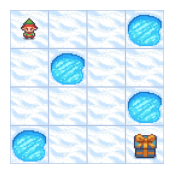

In [2]:
# FrozenLake-v1 gym environment
difficult_map = ["SFFH","FHFF","FFFH","HFFG"]
env = gym.make("FrozenLake-v1",
               desc=difficult_map,
               render_mode="rgb_array",
               is_slippery=False)
env.reset()
_ = display_env(env)

Pour ce jeu, le nombre d'actions possibles est de 4, indicées par un entier : 

 - 0 : déplacement vers la gauche
 - 1 : déplacement vers le bas
 - 2 : déplacement vers la droite
 - 3 : déplacement vers le haut

et le nombre d'états est de 16, correspondant aux cases du jeu. La case 0 est la case de départ, et la case 15 est la case du trésor (qui ne bouge pas), les trous de glaces sont fixes tant qu'on ne génère pas un nouvel environnement, tandis qu'on peut remettre à zéro le jeu en faisant `env.reset()`.

Une partie se termine lorsque soit 
 - on tombe dans un trou, auquel cas la récompense est nulle
 - on trouve le trésor, auquel cas la récompense est de `1`

Pour toutes les autres cases, la récompense est de `0`.

Effectuons une action aléatoire, et voyons comment réagit l'environnement. Dans le code ci-dessous, `state` est l'état $S_t$, et `action` est l'action $A_t$ à l'instant $t$.

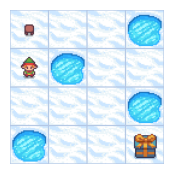

In [3]:
state, info = env.reset()
action = env.action_space.sample()
new_state, reward, terminated, truncated, info = env.step(action)

_ = display_env(env)

Déplacer le pion dans son environnement d'une `action`, c'est faire un `env.step(action)`, qui renvoi cinq objets différents : 

 - `new_state` : le nouvel état dans lequel se trouve le pion une fois l'action effectuée, c'est $S_{t+1}$
 - `reward`, la récompense $R_{t+1}$, 
 - `terminated` et `truncated`, qui sont deux booléens, le premier signifiant que la partie est finie (soit que l'on est tombé dans un trou, soit que l'on soit arrivé sur le trésor), le second signifiant que la partie a atteint son nombre maximum d'étapes possibles (cle nombre maximal autorisé d'appel de `env.step(action)` est un paramètre que l'on peut changer à l'instanciation de l'environnement)
 - `info` permet de rajouter des informations sur le jeu au fur et à mesure de l'avancement de la partie (on ne l'utilisera pas ici)

On peut continuer à agir de façon aléatoire jusqu'à ce que le jeu s'arrête, en ayant pris soin de collecter les différentes actions et états à chaque étape, pour pouvoir les rejouer dans une petite vidéo.

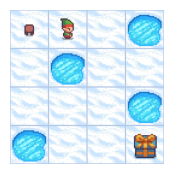

In [4]:
state, info = env.reset()
terminated, truncated = False, False
actions, states, rewards, infos = [], [state,], [0.0], []
frames = []
while (not terminated) and (not truncated):
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    actions.append(action)
    states.append(state)
    rewards.append(reward)
    infos.append(info)
    frames.append(env.render())

plot_animation(frames, repeat=True)

Cette stratégie de jeu au hasard et sans mémoire entre les différentes parties est sans doute peu pertinente. On va maintenant étudier comment améliorer les stratégies du joueur.

## Stratégie de jeu et réaction de l'agent

Voyons maintenant comment construire un jeu autonome. Il s'agit essentiellement de créer un agent autonome. 

Créons un agent typique, sous la forme d'un objet `BaseAgent` pour l'instant vide, et créons en même temps les règles du jeu, sous la forme d'une fonction `play_game`, le tout dans un module `reinforcement_learning` sous-jacent.

À la fin d'une partie, on va récupérer l'ensemble des états, des actions, des récompenses et des infos obtenues par l'agent pendant la partie, sous la forme de listes. Notons que la listes `states` contiendra un état de plus que les listes `actions` ou `rewards`. On récupère enfin une liste d'images nous permettant de rejouer la partie et de l'illustrer.

### Agent aléatoire n'apprenant rien

Créons maintenant l'agent `RandomAgent` qui se déplace de façon aléatoire, et la fonction d'apprentissage `learn_game`.

In [5]:
class RandomAgent(BaseAgent):
    def __init__(self, env):
        self.possible_actions = list(range(env.action_space.n))
        return None
    def reset(self, state):
        return None
    def play(self, env, obs):
        return np.random.choice(self.possible_actions)
    def update(self,
               actions: List[gym.core.ActType],
               states: List[gym.core.ObsType],
               rewards: List[float],
               infos: List[dict]) -> None:
        return None

Notre agent n'apprend rien, il se déplace toujours aléatoirement, comme on peut le voir dans ces vidéos successives : 

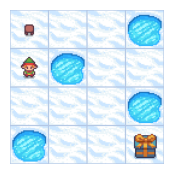

In [6]:
agent = RandomAgent(env)
actions, states, rewards, infos, frames = play_game(env, agent)

plot_animation(frames, repeat=True)

On entraîne maintenant l'agent, et on rejoue une dernière partie, aléatoire également. La seule différence entre une partie d'entraînement et une partie de test consiste à renvoyer toutes les actions réalisées et les récompenses récupérées pendant la partie dans la méthode `update` de l'agent. Dans notre cas, cette méthode ne fait rien du tout, et l'agent n'apprend vraiment rien après la dernière partie.

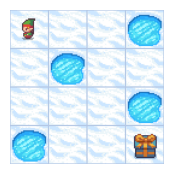

In [7]:
agent = RandomAgent(env)
learn_game(env, agent, nb_total_games=150)
actions, states, rewards, infos, frames = play_game(env, agent)

plot_animation(frames, repeat=True)

### Agent à marche aléatoire apprenant à ne pas retomber dans un trou (et à ne plus se cogner contre les bords)

Pour illustrer le processus d'apprentissage, réalisons le modèle de l'agent qui apprend à ne pas retomber dans un trou qu'il aurait déjà visité. L'agent n'est donc plus le pion, mais le contrôleur du pion, qui peut se permettre de rejouer autant de fois qu'il le désire une partie. Suivant le temps qu'il faudra être tombé dans tous les trous, l'agent va apprendre plus ou moins vite.

Créons tout d'abord l'agent en question

In [8]:
class RememberHolesAgent(BaseAgent):
    def __init__(self, env):
        self.policy = {i: list(range(env.action_space.n)) 
                       for i in range(env.observation_space.n)}
        return None
    def reset(self, state):
        return None
    def play(self, env, obs):
        self.action = np.random.choice(self.policy[obs])
        return self.action
    def update(self,
               actions: List[gym.core.ActType],
               states: List[gym.core.ObsType],
               rewards: List[float],
               infos: List[dict]) -> None:
        # enter in hole
        if rewards[-1] == 0.0:
            if len(self.policy[states[-2]]) > 1:
                self.policy[states[-2]].remove(actions[-1])
        # did not move (next move toward the wall)
        for s, a, s_prime in zip(states[:-1], actions, states[1:]):
            if s == s_prime:
                try:
                    self.policy[s].remove(a)
                except ValueError: # already withdrawn
                    pass
        return None

À l'instanciation de l'agent, on créé un dictionnaire d'actions possible, pour l'ensemble des cases de la partie. On suppose donc que la taille du plateau est connue : c'est une des règles du jeu. Quand on lui demande de choisir une action, l'agent choisit au hasard parmi les actions possibles. On appelle ce dictionnaire d'actions possible la stratégie de jeu de l'agent (_policy_, attention à ne pas confondre la stratégie de jeu et la stratégie d'apprentissage, dont on parle ensuite). Au départ, l'agent fait des choix au hasard, c'est sa stratégie initiale.

Il va affiner sa stratégie initiale en rejouant de nombreuses fois des parties. 

Dans la méthode `update`, on suppose que l'agent se remémore tous les évènements de la dernière partie, et adapte les actions possibles : s'il n'a rien reçu, c'est qu'il est tombé dans un trou (il faut que le nombre d'étapes de la partie soit assez long pour permettre à coup sûr de tomber dans un trou, ou de réussir, c'est le point faible de cette stratégie), et donc il oublie de rejouer la même action s'il revient dans le même état précédant la chute. C'est sa stratégie d'apprentissage (_learn_, ou _update_).

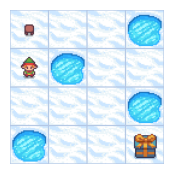

In [9]:
agent = RememberHolesAgent(env)
actions, states, rewards, infos, frames = play_game(env, agent)

plot_animation(frames, repeat=True)

Voyons ce qui se passe pour la stratégie d'apprentissage de l'agent avant

In [10]:
agent.policy

{0: [0, 1, 2, 3],
 1: [0, 1, 2, 3],
 2: [0, 1, 2, 3],
 3: [0, 1, 2, 3],
 4: [0, 1, 2, 3],
 5: [0, 1, 2, 3],
 6: [0, 1, 2, 3],
 7: [0, 1, 2, 3],
 8: [0, 1, 2, 3],
 9: [0, 1, 2, 3],
 10: [0, 1, 2, 3],
 11: [0, 1, 2, 3],
 12: [0, 1, 2, 3],
 13: [0, 1, 2, 3],
 14: [0, 1, 2, 3],
 15: [0, 1, 2, 3]}

et après cette partie

In [11]:
agent.update(actions, states, rewards, infos)
agent.policy

{0: [0, 1, 2],
 1: [0, 2],
 2: [0, 1, 2],
 3: [0, 1, 2, 3],
 4: [0, 1, 2, 3],
 5: [0, 1, 2, 3],
 6: [0, 1, 2, 3],
 7: [0, 1, 2, 3],
 8: [0, 1, 2, 3],
 9: [0, 1, 2, 3],
 10: [0, 1, 2, 3],
 11: [0, 1, 2, 3],
 12: [0, 1, 2, 3],
 13: [0, 1, 2, 3],
 14: [0, 1, 2, 3],
 15: [0, 1, 2, 3]}

On voit que sa stratégie de jeu a été mise à jour par sa stratégie d'apprentissage. La case précédent la chute ne présente plus l'action possible conduisant au trou. De plus, s'il s'est cogné contre un bord, il ne recommencera plus.

```{admonition} Autres stratégies possibles
:class: hint
On aurait pu choisir de supprimer _toutes_ les actions possibles conduisant au trou identifié. Il faut alors supposer que l'agent possède, en plus de la taille de la carte, la carte elle même, et qu'il biffe la position du trou de ses possibilités d'explorations futures.
```

Faisons lui faire de multiples expériences, et regardons la stratégie de jeu finale.

In [12]:
learn_game(env, agent, nb_total_games = 25)
agent.policy

{0: [1, 2],
 1: [0, 2],
 2: [0, 1],
 3: [0, 1, 2, 3],
 4: [3],
 5: [0, 1, 2, 3],
 6: [1, 2, 3],
 7: [0],
 8: [2, 3],
 9: [0, 1, 2],
 10: [0, 1, 3],
 11: [0, 1, 2, 3],
 12: [0, 1, 2, 3],
 13: [2, 3],
 14: [0, 2, 3],
 15: [0, 1, 2, 3]}

Puis faisons une dernière partie

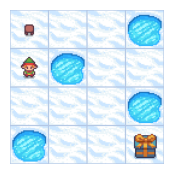

In [13]:
actions, states, rewards, infos, frames = play_game(env, agent)
plot_animation(frames, repeat=True)

Pour conclure sur cet apprentissage, calculons le nombre de parties gagnées pour une centaine de partie jouées.

In [14]:
final_rewards = []
for _ in range(100):
    actions, states, rewards, infos, frames = play_game(env, agent)
    final_rewards.append(rewards[-1])
print("{:,}/100 parties gagnées".format(int(sum(final_rewards))))

71/100 parties gagnées


Les parties non gagnées sont des parties qui durent trop longtemps tellement le parcours est difficile.

```{admonition} Carte plus difficile encore
:class: exercice
Réessayer avec une carte encore plus difficile, plus longue, avec plus de piège et un seul chemin possible, ... , 

Par example `difficult_map = ["SFFFF","HHHHF","FFFFF", "FHHHH","FFFFG"]`.
```

### Carte aléatoire

On a donc réussi à déjouer les pièges du labyrinthe par une stratégie d'apprentissage adéquate et une stratégie de jeu aléatoire à possibilités de plus en plus restreinte.

Néanmoins, notre stratégie était payant puisque la carte ne bougeait pas. On peut se demander si notre stratégie serait payante face un environnement aléatoire. Testons cette idée à l'aide de la même carte et du même agent, mais lorsque les cases glacées sont glissantes (option `is_slippery=True`), auquel cas l'état de l'agent une fois effectuée son action par l'environnement est aléatoire également : il a un tier de chance d'aller dans chacune des directions qui ne sont pas son état précédent.

On ne montre pas de séquence vidéo pour cette étape, on se contente de calculer le résultat final.

In [15]:
envslippery = gym.make("FrozenLake-v1",
                       desc=difficult_map,
                       render_mode="rgb_array",
                       is_slippery=True)
envslippery.reset()

final_rewards = []
for _ in range(100):
    actions, states, rewards, infos, frames = play_game(envslippery, agent)
    final_rewards.append(rewards[-1])
print("{:,}/100 parties gagnées".format(int(sum(final_rewards))))

0/100 parties gagnées


In [16]:
tet = dt.now() - tet
tet = tet.total_seconds()
print("Temps total d'éxécution {:.2f}s".format(tet))
print("Dernière modification {}".format(dt.now().strftime("%d/%m/%Y")))

Temps total d'éxécution 23.48s
Dernière modification 22/02/2023
